Precalculate the last convolutional layer of restnet50 for `train`, `valid` and `test` datasets to use in other notebooks.

For the test dataset we merge the stg1 and stg2 data since thats how you can make a late submission to the competition.

In [1]:
import numpy as np
import tensorflow as tf
import bcolz

## Use base keras instead of tf.keras because of: https://github.com/tensorflow/tensorflow/issues/11868
# from tensorflow.contrib.keras.python.keras import applications
# from tensorflow.contrib.keras.python.keras.preprocessing import image
# from tensorflow.contrib.keras.python.keras.applications import imagenet_utils
##
from keras import applications
from keras.preprocessing import image
from keras.applications import imagenet_utils
from keras.utils import np_utils
##

Using TensorFlow backend.


In [2]:
target_size = (224, 224)

Load data into np arrays

In [3]:
def get_batches(dirpath, gen=image.ImageDataGenerator(), target_size=(224, 224), shuffle=True, batch_size=64, class_mode='categorical'):
    return gen.flow_from_directory(dirpath, target_size=target_size, class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

In [4]:
train_batches = get_batches('./data/train', shuffle=False, batch_size=1, class_mode=None, target_size=target_size)

Found 3025 images belonging to 8 classes.


In [5]:
train_batches.samples

3025

In [6]:
train_data = np.concatenate([train_batches.next() for i in range(train_batches.samples)])

In [7]:
train_data.shape

(3025, 224, 224, 3)

In [8]:
valid_batches = get_batches('./data/valid', shuffle=False, batch_size=1, class_mode=None, target_size=target_size)

Found 752 images belonging to 8 classes.


In [9]:
valid_data = np.concatenate([valid_batches.next() for i in range(valid_batches.samples)])

In [10]:
valid_data.shape

(752, 224, 224, 3)

Merge the two test datasets into one

In [11]:
test_stg1_batches = get_batches('./data/test_stg1', shuffle=False, batch_size=1, class_mode=None, target_size=target_size)

Found 1000 images belonging to 1 classes.


In [12]:
test_stg1_data = np.concatenate([test_stg1_batches.next() for i in range(test_stg1_batches.samples)])

In [13]:
test_stg1_data.shape

(1000, 224, 224, 3)

In [14]:
test_stg2_batches = get_batches('./data/test_stg2', shuffle=False, batch_size=1, class_mode=None, target_size=(224, 224))

Found 12153 images belonging to 1 classes.


In [15]:
test_stg2_data = np.concatenate([test_stg2_batches.next() for i in range(test_stg2_batches.samples)])

In [16]:
test_stg2_data.shape

(12153, 224, 224, 3)

In [17]:
test_data = np.concatenate([test_stg1_data, test_stg2_data])

In [18]:
test_data.shape

(13153, 224, 224, 3)

Predict the the 3 datasets

In [19]:
resnet50 = applications.ResNet50(weights='imagenet', include_top=False, pooling='max')

In [20]:
train_pred = resnet50.predict(train_data)

In [21]:
train_pred.shape

(3025, 2048)

In [22]:
valid_pred = resnet50.predict(valid_data)

In [23]:
valid_pred.shape

(752, 2048)

In [24]:
test_pred = resnet50.predict(test_data)

In [25]:
test_pred.shape

(13153, 2048)

In [26]:
##

In [27]:
def save_array(fname, arr):
    c = bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()

In [28]:
save_array('data/resnet50/train_conv.arr', train_pred)

In [29]:
save_array('data/resnet50/valid_conv.arr', valid_pred)

In [30]:
save_array('data/resnet50/test_conv.arr', test_pred)

Save the labels for `train` and `valid` and filenames for `test`

In [31]:
def onehot(x):
    return np_utils.to_categorical(x)

In [32]:
save_array('data/resnet50/train_labels.arr', onehot(train_batches.classes))

In [33]:
save_array('data/resnet50/valid_labels.arr', onehot(valid_batches.classes))

In [34]:
test_stg1_batches.filenames[0], test_stg2_batches.filenames[0]

('unknown/img_07538.jpg', 'unknown/image_01802.jpg')

In [35]:
test_stg1_batches_filenames = [fname[8:] for fname in test_stg1_batches.filenames]

In [36]:
test_stg2_batches_filenames = ["test_stg2/" + fname[8:] for fname in test_stg2_batches.filenames]

In [37]:
test_stg1_batches_filenames[0], test_stg2_batches_filenames[0]

('img_07538.jpg', 'test_stg2/image_01802.jpg')

In [38]:
test_filenames = test_stg1_batches_filenames + test_stg2_batches_filenames

In [39]:
len(test_filenames)

13153

In [40]:
save_array('data/resnet50/test_filenames.arr', test_filenames)

## Metadata

We have some hand classified borders of the fishes for the images.

We make an array for the train and valid datasets

In [41]:
import json
import PIL

from matplotlib import pyplot as plt
%matplotlib inline

In [42]:
json_files = ["alb_labels.json", 'bet_labels.json', 'dol_labels.json', 'lag_labels.json', 'other_labels.json', 'shark_labels.json', 'yft_labels.json']

In [43]:
annotations = []
for fname in json_files:
    with open('metadata/' + fname, 'r') as f:
        new_data = json.loads(f.read())
        # Add the class to the img name
        for i, item in enumerate(new_data):
            new_data[i]['class'] = fname.split('_')[0]
        annotations += new_data

In [44]:
len(annotations)

3312

In [45]:
# Clean annotations list to a dict by filename e.g. ALB/img_#####.jpg
img_bb = {}
for anno in annotations:
    if 'annotations' in anno.keys() and len(anno['annotations']) > 0:
        # Sort the borders by size
        sorted_borders = sorted(anno['annotations'], key=lambda x: x['height'] * x['width'])
        # Pick the biggest border
        key_name = anno['class'].upper() + '/' + anno['filename'].split('/')[-1]
        img_bb[key_name] = sorted_borders[-1]

In [46]:
# We also need all image sizes so we can resize the borders to 224x224
# Same dict structure like img_bb e.g. ALB/img_#####.jpg
img_sizes = {f: PIL.Image.open('./data/train/' + f).size for f in train_batches.filenames}
img_sizes.update({f: PIL.Image.open('./data/valid/' + f).size for f in valid_batches.filenames})

In [47]:
# Arrays to fill
train_annot = np.zeros((train_data.shape[0], 4))
valid_annot = np.zeros((valid_data.shape[0], 4))

In [48]:
train_annot.shape, valid_annot.shape

((3025, 4), (752, 4))

In [49]:
bb_params = ['x', 'y', 'width', 'height']

In [50]:
def convert_bb(bb, size):
    # Resize the border to the image size
    bb = [bb[p] for p in bb_params]
    conv_x = (target_size[0] / size[0])
    conv_y = (target_size[1] / size[1])
    bb[0] = max(bb[0] * conv_x, 0)
    bb[1] = max(bb[1] * conv_y, 0)
    bb[2] = bb[2] * conv_x
    bb[3] = bb[3] * conv_y
    return bb

In [51]:
# Iterate every filename dataset and get the annotation if exists
for i, fname in enumerate(train_batches.filenames):
    if fname not in img_bb:
        continue
    anott = img_bb[fname]
    size = img_sizes[fname]
    train_annot[i, :] = convert_bb(anott, size)

In [52]:
train_annot[:3]

array([[ 138.82874419,  117.90126895,   58.95063447,   53.71057808],
       [ 125.71959685,   33.24815784,   62.13249497,   42.11433327],
       [ 125.49442006,   88.41760446,   22.5246395 ,   18.91520891]])

Plot to test that borders are ok

In [53]:
def to_plot(img):
    return np.rollaxis(img, 0, 1).astype(np.uint8)

def plot(img):
    plt.imshow(to_plot(img))
    
def create_rect(bb, color='red'):
    return plt.Rectangle((bb[0], bb[1]), bb[2], bb[3], color=color, fill=False, lw=3)

def show_bb(i=0):
    bb = train_annot[i]
    plot(train_data[i])
    plt.gca().add_patch(create_rect(bb))

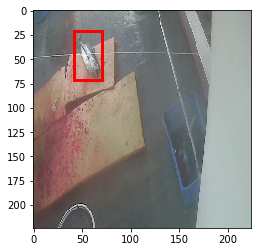

In [54]:
show_bb(8)

Now thats its ok, computate valid boxes and save the arrays

In [55]:
for i, fname in enumerate(valid_batches.filenames):
    if fname not in img_bb:
        continue
    anott = img_bb[fname]
    size = img_sizes[fname]
    valid_annot[i, :] = convert_bb(anott, size)

In [56]:
valid_annot[:3]

array([[ 135.46575   ,   59.65866667,   54.285     ,   57.904     ],
       [  86.02960842,   76.84018702,   62.13249497,   90.13945015],
       [ 141.925     ,    0.896     ,   44.625     ,   47.18933333]])

In [57]:
save_array('data/resnet50/train_borders.arr', train_annot)

In [58]:
save_array('data/resnet50/valid_borders.arr', valid_annot)